# Dykstra-Style Repair from Samples

We will generate synthetic group-conditional samples, estimate distributions, and then apply  

1.  a baseline coupling,

2.  partial repairs (two different theta's), and

3.  the full (total) repair via a GroupBlindRepair wrapper,

visualizing both the projected PMFs and the learned couplings.

## Imports & setup

In [1]:
import math
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
path=os.path.dirname(os.getcwd())

# from humancompatible.repair.methods.cost import c_generate, normalise
# from humancompatible.repair.methods.coupling_utils import tmp_generator
# from humancompatible.repair.methods.metrics import newton
# from humancompatible.repair.group_blind_repair import GroupBlindRepair

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if not os.path.exists('../plots'):
    os.makedirs('../plots')

### Overview of Core Components

We define two main classes in our framework:

- **`repairmap_algorithms`**:  
  Implements the core algorithm in our paper.  
  Responsible for computing the **coupling matrix** (transport map) at a specified **repair rate**.

- **`motivating_example`**:  
  Used for generating **synthetic data**, computing projections using given couplings, and producing visualizations.  
  Designed to illustrate the behavior of our algorithm in a simple, controlled example.


In [ ]:
class repairmap_algorithms:
    """
    A class to compute coupling used for repair at given repair rate.
    A baseline function that compute plain optimal transport (OT) coupling is also includes 
    """

    def __init__(self,source_dist,target_dist,v_vector,x_range):
        self.x_range = x_range
        self.bin=len(self.x_range)
        self.C= self.c_generate()
        self.e=0.01 # parameter for entropy regularization in plain OT
        self.px=np.matrix(source_dist).T # source distribution (group-blind)  #dist['x']
        self.ptx=np.matrix(target_dist).T # target distribution #dist['t_x']
        self.V=np.matrix(v_vector).T # the normalized difference between group-wise distributions. # dist['v']
        self.K=200 # number of iterations

    def c_generate(self):
        x_range=self.x_range
        # Compute the cost matrix for optimal transport using pairwise absolute differences
        x_range = np.array(x_range).reshape(-1, 1)  # Reshape to 2D array for cdist
        C = cdist(x_range, x_range, metric='cityblock')  # 'cityblock' computes absolute differences
        return C
    
    # plain OT
    def baseline(self): 
        bbm1=np.matrix(np.ones(self.bin)).T
        xi=np.exp(-self.C/self.e)
        gamma_classic=dict()
        gamma_classic[0]=np.matrix(xi+1.0e-9)
        for repeat in range(self.K):
            gamma_classic[1+2*repeat]=np.matrix(np.diag((self.px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
            gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((self.ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

        # assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
        return gamma_classic[2*self.K]

    def tmp_generator(slef,gamma_dict,num,q_dict,q_num,L):
        bin=gamma_dict[0].shape[0]
        if q_num<=0:
            q=np.matrix(np.ones((bin,bin)))
        else:
            q=q_dict[q_num]
        tmp_gamma=np.ones((bin,bin))
        tmp_q=np.ones((bin,bin))
        for i in range(bin):
            for j in range(bin):
                tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
                tmp_gamma[i,j]=tmp_q[i,j]*gamma_dict[num-1].item(i,j)
        return np.matrix(tmp_gamma),np.matrix(tmp_q)  

    def newton(self,fun, dfun, initial, stepmax, tol):
        if abs(fun(initial))<=tol: return initial
        for step in range(1, stepmax+1):
            b=initial-fun(initial)/dfun(initial)
            if abs(fun(b))<=tol:
                return b
            else:
                initial = b
        return b 

    # our method | total repair
    def total_repair(self): #C,e,px,ptx,V,K

        bbm1=np.matrix(np.ones(self.bin)).T
        I=np.where(~(self.V==0))[0].tolist()
        xi=np.exp(-self.C/self.e)
        gamma_dict=dict()
        gamma_dict[0]=np.matrix(xi+1.0e-9) #+1.0e-9
        gamma_dict[1]=np.matrix(np.diag((self.px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
        gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((self.ptx/(gamma_dict[1].T @ bbm1)).A1))
        # step 3
        J=np.where(~((gamma_dict[2].T @ self.V).A1 ==0))[0].tolist()
        nu=np.zeros(bin)
        gamma_dict[3]=np.copy(gamma_dict[2])
        for j in J:
            fun = lambda z: sum(gamma_dict[2].item(i,j)*self.V.item(i)*np.exp(z*self.V.item(i)) for i in I)
            dfun = lambda z: sum(gamma_dict[2].item(i,j)*(self.V.item(i))**2*np.exp(z*self.V.item(i)) for i in I)
            nu = self.newton(fun,dfun,initial=0,stepmax = 50,tol = 1.0e-9)
            for i in I:
                gamma_dict[3][i,j]=np.exp(nu*self.V.item(i))*gamma_dict[2].item(i,j)
        gamma_dict[3]=np.matrix(gamma_dict[3])

        #=========================
        L=3
        q_dict=dict()

        for loop in range(1,self.K):
            if np.any(gamma_dict[(loop-1)*L+1]==0):
                break
            tmp,q_dict[(loop-1)*L+1]=self.tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) 
            gamma_dict[loop*L+1]=np.matrix(np.diag((self.px/(tmp @ bbm1)).A1))@tmp
            
            if np.any(gamma_dict[(loop-1)*L+2]==0):
                break
            tmp,q_dict[(loop-1)*L+2]=self.tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L) 
            gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((self.ptx/(tmp.T @ bbm1)).A1))

            # step 3
            if np.any(gamma_dict[(loop-1)*L+3]==0):
                break
            tmp,q_dict[(loop-1)*L+3]=self.tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L) 
            J=np.where(~((abs(np.matrix(tmp).T @ self.V).A1)<=1.0e-4))[0].tolist()
            gamma_dict[loop*L+3]=np.copy(tmp)
            for j in J:
                fun = lambda z: sum(tmp.item(i,j)*self.V.item(i)*np.exp(z*self.V.item(i)) for i in I)
                dfun = lambda z: sum(tmp.item(i,j)*(self.V.item(i))**2*np.exp(z*self.V.item(i)) for i in I)
                nu = self.newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-4) 
                for i in I:
                    gamma_dict[loop*L+3][i,j]=np.exp(nu*self.V.item(i))*tmp.item(i,j)
            gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])
            
            if sum(abs(gamma_dict[loop*L+3].T@self.V))<=1.0e-9:  #'tr violation:'
                break;

        # assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*(loop+1)])
        return gamma_dict[L*(loop+1)]

    # our method | partial repair
    def partial_repair(self,theta_scale=1.0e-2):
        bbm1=np.matrix(np.ones(self.bin)).T
        I=np.where(~(self.V==0))[0].tolist()
        xi=np.exp(-self.C/self.e)
        theta=bbm1*theta_scale
        gamma_dict=dict()
        gamma_dict[0]=np.matrix(xi+1.0e-9)
        gamma_dict[1]=np.matrix(np.diag((self.px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
        gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((self.ptx/(gamma_dict[1].T @ bbm1)).A1))
        # step 3
        Jplus=np.where(~((gamma_dict[2].T @ self.V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((gamma_dict[2].T @ self.V).A1>=-theta.A1))[0].tolist()
        gamma_dict[3]=np.copy(gamma_dict[2])
        for j in Jplus:
            fun = lambda z: sum(gamma_dict[2].item(i,j)*self.V.item(i)*np.exp(-z*self.V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(self.V.item(i))**2*np.exp(-z*self.V.item(i)) for i in I)
            nu = self.newton(fun,dfun,initial=0,stepmax = 50,tol = 1.0e-9) 
            for i in I:
                gamma_dict[3][i,j]=np.exp(-nu*self.V.item(i))*gamma_dict[2].item(i,j)
        for j in Jminus:
            fun = lambda z: sum(gamma_dict[2].item(i,j)*self.V.item(i)*np.exp(-z*self.V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(self.V.item(i))**2*np.exp(-z*self.V.item(i)) for i in I)
            nu = self.newton(fun,dfun,initial=0,stepmax = 50,tol = 1.0e-9)
            for i in I:
                gamma_dict[3][i,j]=np.exp(-nu*self.V.item(i))*gamma_dict[2].item(i,j)
        gamma_dict[3]=np.matrix(gamma_dict[3])

        #=========================
        L=3
        q_dict=dict()
        for loop in range(1,self.K):
            if np.any(gamma_dict[(loop-1)*L+1]==0):
                break
            tmp,q_dict[(loop-1)*L+1]=self.tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) 
            gamma_dict[loop*L+1]=np.matrix(np.diag((self.px/(tmp @ bbm1)).A1))@tmp
            if np.any(gamma_dict[(loop-1)*L+2]==0):
                break
            tmp,q_dict[(loop-1)*L+2]=self.tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  
            gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((self.ptx/(tmp.T @ bbm1)).A1))

            # step 3
            if np.any(gamma_dict[(loop-1)*L+3]==0):
                break
            tmp,q_dict[(loop-1)*L+3]=self.tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
            Jplus=np.where(~((np.matrix(tmp).T @ self.V).A1 <=theta.A1))[0].tolist()
            Jminus=np.where(~((np.matrix(tmp).T @ self.V).A1>=-theta.A1))[0].tolist()
            gamma_dict[loop*L+3]=np.copy(tmp)
            for j in Jplus:
                fun = lambda z: sum(tmp.item(i,j)*self.V.item(i)*np.exp(-z*self.V.item(i)) for i in I)-theta.item(j)
                dfun = lambda z: -sum(tmp.item(i,j)*(self.V.item(i))**2*np.exp(-z*self.V.item(i)) for i in I)
                nu = self.newton(fun,dfun,0,stepmax = 50,tol = 1.0e-9) 
                for i in I:
                    gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
            for j in Jminus:
                fun = lambda z: sum(tmp.item(i,j)*self.V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
                dfun = lambda z: -sum(tmp.item(i,j)*(self.V.item(i))**2*np.exp(-z*self.V.item(i)) for i in I)
                nu = self.newton(fun,dfun,0.5,stepmax = 50,tol = 1.0e-9) 
                for i in I:
                    gamma_dict[loop*L+3][i,j]=np.exp(-nu*self.V.item(i))*tmp.item(i,j)
            gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])
            if sum(abs(gamma_dict[loop*L+3].T@self.V))<1.0e-5:  #'tr violation:'
                break;
        
        # assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*(loop+1)])
        return gamma_dict[L*(loop+1)]

In [ ]:
class motivating_example:
    """
    A class for generating synetic data & plots,
    projecting data using given couplings, 
    """

    def __init__(self, para, sample_size):
        self.para = para
        self.sample_size = sample_size

        # Discretize the input range
        self.x_range = np.arange(*para['horizon'], para['width'])
        self.num_bins = len(self.x_range)

        # Generate and group samples
        raw_df = self.data_generation()
        self.df = self.samples_groupby(raw_df)

        # Analyze empirical distribution
        self.dist = self.rdata_analysis(self.df)

        # Compute group proportions (s_0 and s_1)
        weight_s0 = self.df[self.df['S'] == '0']['W'].sum()
        weight_s1 = self.df[self.df['S'] == '1']['W'].sum()
        self.dist['s'] = [weight_s0 / sample_size, weight_s1 / sample_size]

        # Compute target distribution t_x over x_range
        t_x_raw = [self.Gaussian_pdf(x, 'X_t') * para['width'] for x in self.x_range]
        self.dist['t_x'] = self.normalise(t_x_raw)  # Ensure t_x sums to 1

        # Compute vector v = (x_0 - x_1) / x
        self.dist['v'] = (self.dist['x_0'] - self.dist['x_1']) / self.dist['x']

    def data_generation(self):
        x_min, x_max = self.para['horizon']
        
        X_vals = []
        S_vals = []

        for _ in range(self.sample_size):
            if np.random.rand() < self.para['s_0']:
                mean, sd, s_label = self.para['X_0_mean'], self.para['X_0_sd'], '0'
            else:
                mean, sd, s_label = self.para['X_1_mean'], self.para['X_1_sd'], '1'
            
            X = int(np.floor(np.random.normal(mean, sd)))
            X = np.clip(X, x_min, x_max - 1)  # ensure X is in the range

            X_vals.append(X)
            S_vals.append(s_label)

        df = pd.DataFrame({
            'X': X_vals,
            'S': S_vals,
            'W': 1
        })

        return df
    
    def samples_groupby(self, data):
        """
        Groups the dataset by ['X', 'S'] and sums the weights ('W') for duplicate entries.
        Removes any entries with zero total weight.
        """
        grouped = data.groupby(['X', 'S'], as_index=False)['W'].sum()
        return grouped[grouped['W'] != 0]
    
    def rdata_analysis(self,rdata):
        """
        Computes empirical distributions over x_range for:
        - the full dataset
        - the subset where S == '0'
        - the subset where S == '1'
        
        Returns a dictionary with keys 'x', 'x_0', and 'x_1'.
        """
        # Precompute subsets
        s0 = rdata[rdata['S'] == '0']
        s1 = rdata[rdata['S'] == '1']

        return {
            'x': self.empirical_distribution(rdata),
            'x_0': self.empirical_distribution(s0),
            'x_1': self.empirical_distribution(s1),
        } 
    
    def empirical_distribution(self,sub):
        """
        Computes the empirical distribution over x_range using weights 'W' 
        from the DataFrame sub, where 'X' values match elements in x_range.
        """
        # Map x_range to corresponding weights
        weight_by_x = sub.groupby('X')['W'].sum()

        # Align weights with x_range
        distribution = np.array([weight_by_x.get(x, 0) for x in self.x_range])

        total = distribution.sum()
        return distribution / total if total > 0 else distribution

    def projection(self, coupling_matrix):
        # Return projected data using a group-blind coupling.
        bin_count = self.num_bins
        coupling = coupling_matrix.A1.reshape((bin_count, bin_count))

        loc_dict = {x: i for i, x in enumerate(self.x_range)}
        projected_rows = []

        for _, orig in self.df.iterrows():
            loc = loc_dict[orig['X']]
            weights = coupling[loc] / coupling[loc].sum() * orig['W']

            sub = pd.DataFrame({
                'X': self.x_range,
                'W': weights,
                'S': orig['S']  # broadcasted to all rows
            })

            processed = self.samples_groupby(sub)
            projected_rows.append(processed)

        df_t = pd.concat(projected_rows, ignore_index=True)
        return df_t
    
    def normalise(self,tem_dist):
        tem_dist = np.array(tem_dist)
        return tem_dist / tem_dist.sum()
    
    def Gaussian_pdf(self,x,name):
        mu=self.para[name+'_mean']
        sigma=self.para[name+'_sd']
        return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))  

    def plots(self,couplings_matrix):
        g=self.dist['x']
        f=self.dist['t_x']
        output=couplings_matrix
        fig = plt.figure(figsize=(3,3))
        gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
        # Create the Axes.
        ax = fig.add_subplot(gs[1, 0])
        ax.pcolormesh(self.x_range, self.x_range, output, cmap='Blues')
        ax.set_xlabel(r'supp($X$)',fontsize=10)
        ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histx.tick_params(axis="y", labelleft=False)
        ax_histy.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        ax_histx.plot(self.x_range,g,color='tab:blue')
        ax_histy.plot(f,self.x_range,color='tab:green') 
        return fig

### Synthetic Data Generation

We generate synthetic data with a single feature, **X**, where the distribution of **X** differs across two groups. Specifically:

* Each group's feature distribution follows a **Gaussian (normal) distribution** with group-specific mean and standard deviation.
* A binary group label **S ∈ {0, 1}** is assigned probabilistically according to a fixed mixture weight.
* Given the group label, **X** is sampled from the corresponding Gaussian distribution.

This setup effectively creates data drawn from a **mixture of Gaussians**, where the overall distribution of **X** is a weighted combination of the group-specific Gaussian components.


In [ ]:
# definition of parameters
np.random.seed(seed=1) 

para = {
    # distribution of the first group:
    'X_0_mean': -10, 'X_0_sd': 6, 
    # distribution of the second group:
    'X_1_mean': 1, 'X_1_sd': 3, 
    # target distribution:
    'X_t_mean': -5, 'X_t_sd': 5,
    # weights of two groups
    's_0': 0.7, 's_1': 0.3,
    # support set 
    'horizon': (-30, 10), 'width': 1
}

M=10000 # sample size of this dataset
example = motivating_example(para=para,sample_size=M)

### Overview of the Generated Data and Distributions (PMF)

The plot below illustrates the **probability mass functions (PMFs)** of the feature **X** for different distributions:

* **Blue curve**: The **group-blind distribution** — the overall distribution of X, aggregated across both groups.
* **Yellow and purple curves**: The **group-conditional distributions** — the distribution of X within each group (e.g., group 0 and group 1), each following a Gaussian.
* **Green curve**: An **arbitrary target distribution** that we aim to project the group-blind distribution onto, often for fairness or reweighting purposes.


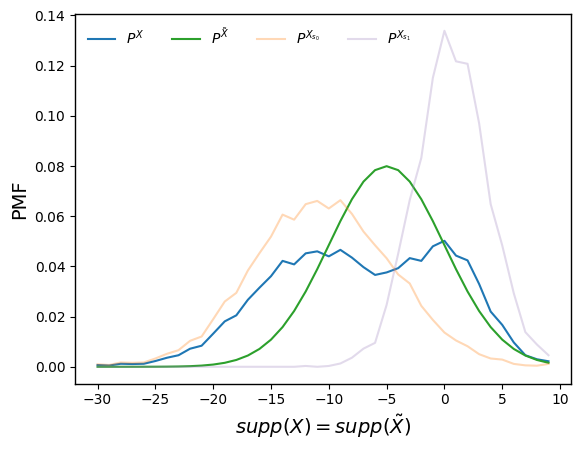

In [ ]:
x_range=example.x_range
dist=example.dist
plt.plot(x_range,dist['x'],label=r'$P^{X}$',color='tab:blue')
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist['x_0'],label=r'$P^{X_{s_0}}$',alpha=0.3,color='tab:orange')
plt.plot(x_range,dist['x_1'],label=r'$P^{X_{s_1}}$',alpha=0.3,color='#9f86c0')
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=14)
plt.legend(ncol=4,frameon=False)
plt.savefig(path+'/plots/SourceTarget_example.pdf',bbox_inches = 'tight')

### Coupling Matrix Computation

We define a class to compute the **coupling matrix**, which corresponds to a **transport map** between distributions.

This class takes the following inputs:

* **Source distribution**: The **group-blind distribution** of the feature X, representing the empirical mixture of group-wise distributions.
* **Target distribution**: An arbitrary target distribution that we aim to project onto, typically to enforce certain properties (e.g., fairness or debiasing).
* **Vector $v$**: A vector encoding the **normalized difference** between the two group-conditional distributions. It provides directional information for transport.
* **Support $\mathcal{X}$**: The discrete **support set** (`x_range`) over which all distributions are defined.

The goal is to construct a coupling (i.e., a joint distribution) that transports the source distribution to the target while respecting the structure imposed by $v$.

In [ ]:
couplings=repairmap_algorithms(source_dist=dist['x'],
                               target_dist=dist['t_x'],
                               v_vector=dist['v'],
                               x_range=example.x_range)

### Coupling Computation (Example)

We provide several options for computing the **coupling matrix**, depending on how strictly we want to incorporate the group-conditional differences (encoded in the $v$ vector):

* **`baseline`**:
  Performs standard **Optimal Transport (OT)** between the source and target distributions.
  No additional constraints related to the $v$ vector are imposed.

* **`partial_repair`** (recommended):
  Enforces constraints related to the group-wise differences **up to a specified tolerance** (e.g., $10^{-2}$).
  This allows partial correction of group disparities while maintaining numerical stability and computational efficiency.

* **`total_repair`**:
  Equivalent to setting the tolerance to **zero**—i.e., requiring the projected data to **fully eliminate the group-wise difference** as measured by $v$.
  While theoretically appealing, this option is not recommended due to high computational cost and potential numerical instability.

Choose the coupling mode based on the trade-off between fairness guarantees and practical feasibility.

In [ ]:
couplings.baseline()
couplings.total_repair()
couplings.partial_repair(theta_scale=1.0e-2)

matrix([[2.97891098e-07, 1.11249597e-15, 1.18677984e-15, ...,
         6.88681555e-06, 3.90705723e-06, 1.24013843e-06],
        [2.12532381e-16, 7.93717637e-07, 8.46715953e-16, ...,
         4.91344427e-06, 2.78751592e-06, 8.84784992e-07],
        [5.10023730e-16, 1.90472072e-15, 2.03190322e-06, ...,
         1.17910182e-05, 6.68933017e-06, 2.12325924e-06],
        ...,
        [1.20098778e-16, 4.48517624e-16, 4.78466157e-16, ...,
         1.72355164e-03, 1.17306937e-12, 5.85307819e-16],
        [9.64858707e-17, 3.60333503e-16, 3.84393784e-16, ...,
         1.69832943e-12, 1.15290039e-03, 6.30816827e-16],
        [4.39203276e-16, 1.64023658e-15, 1.74975888e-15, ...,
         4.79162878e-10, 3.08618914e-10, 1.08904728e-03]])

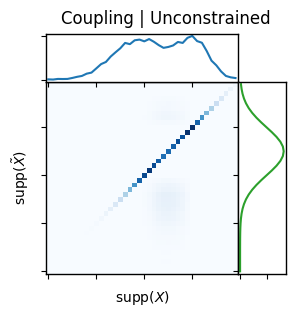

In [ ]:
fig=example.plots(couplings.baseline())
fig.suptitle('Coupling | Unconstrained')
plt.savefig(path+'/plots/coupling_base.pdf',bbox_inches = 'tight')

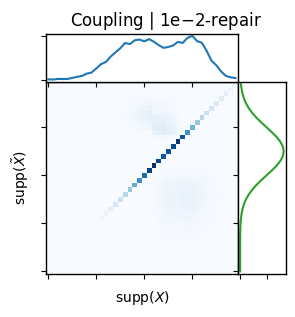

In [ ]:
fig=example.plots(couplings.partial_repair(theta_scale=1.0e-2))
fig.suptitle(r'Coupling | $1\mathrm{e}{-2}$-repair')
plt.savefig(path+'/plots/coupling_part2.pdf',bbox_inches = 'tight')

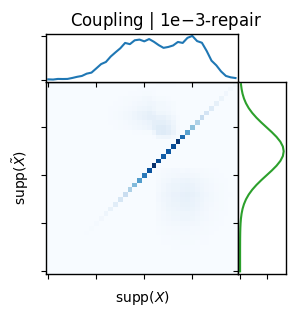

In [ ]:
fig=example.plots(couplings.partial_repair(theta_scale=1.0e-3))
fig.suptitle(r'Coupling | $1\mathrm{e}{-3}$-repair')
plt.savefig(path+'/plots/coupling_part3.pdf',bbox_inches = 'tight')

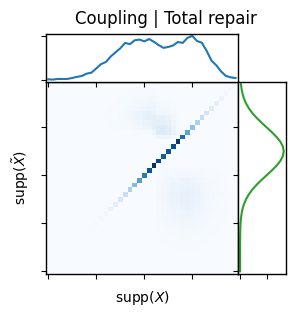

In [ ]:
fig=example.plots(couplings.total_repair())
fig.suptitle('Coupling | Total repair')
plt.savefig(path+'/plots/coupling_total.pdf',bbox_inches = 'tight')

### Data Projection Using the Coupling Matrix

Once the **coupling matrix** (i.e., the projection map) is computed, we use it to **project the original data distribution** onto the target distribution.

The process works as follows:

* For each data point in the original dataset, we use the coupling matrix to redistribute its weight across the support set.
* This redistribution is done in a **group-blind** manner, meaning it does not explicitly depend on the group label, but the transport direction and mass are informed by the computed coupling.
* The output is a **projected dataset** that:

  * Matches the target distribution at the population level,
  * Respects the partial or total correction of group-wise disparities as specified during the coupling computation.


In [ ]:
# computation of couplings and projection
rdata_base=example.projection(couplings.baseline())
rdata_part2=example.projection(couplings.partial_repair(theta_scale=1.0e-2))
rdata_part3=example.projection(couplings.partial_repair(theta_scale=1.0e-3))
rdata_total=example.projection(couplings.total_repair())

### Empirical Distribution of Projected Data

After projecting the original data using the coupling matrix, we compute the **empirical distributions** of the projected dataset to evaluate the effects of the projection.

Specifically, we compute:

* **Group-blind distribution**: The overall distribution of the projected feature $X$, aggregated across all samples.
* **Group-conditional distributions**: The distributions of $X$ within each group $S \in \{0, 1\}$, reflecting how each group has shifted after projection.

These empirical distributions allow us to **quantitatively assess** how closely the projected data matches the desired target distribution and whether the group-wise differences have been effectively reduced or controlled.


In [ ]:
# computation of empirical distributions
dist_origin=example.rdata_analysis(example.df)
rdist_base=example.rdata_analysis(rdata_base)
rdist_part2=example.rdata_analysis(rdata_part2)
rdist_part3=example.rdata_analysis(rdata_part3)
rdist_total=example.rdata_analysis(rdata_total)

### Step 1: Verifying Group-Blind Distribution Alignment

As a first check, we verify whether the **group-blind distribution** of the projected data matches the **target distribution** we specified.

- **Green curve**: the original **target distribution**.
- **Dashed green curve**: the **group-blind distribution** of the projected data.

This is the basic requirement of **optimal transport**:

> The marginal distribution of the projected data should match the target distribution, regardless of the specific coupling used.

✅ **Expected outcome**:  
The dashed green curve should closely align with the solid green curve for any valid coupling method (e.g., `baseline`, `partial_repair`, or `total_repair`).

This confirms that the projection step has correctly redistributed the original data to match the target marginal distribution.

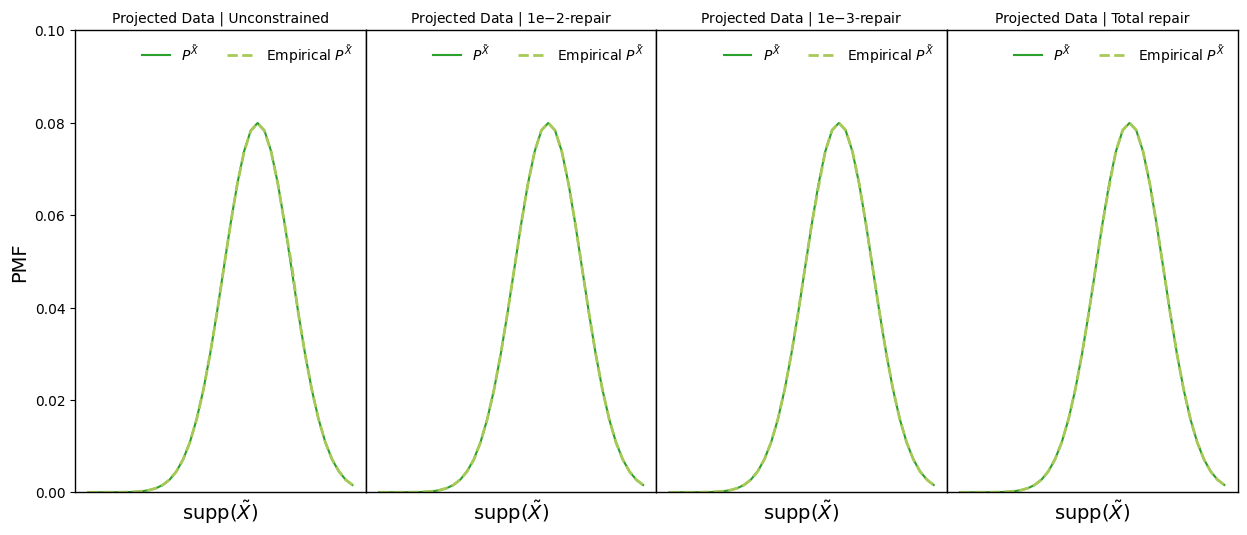

In [ ]:
x_range=example.x_range
dist=example.dist

ymax=0.1
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,4),(0,0), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.xticks([])
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Unconstrained',fontsize=10)
ax=plt.subplot2grid((1,4),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig(path+'/plots/groupblind.pdf',bbox_inches = 'tight')

### Step 2: Verifying Group-Wise Distribution Alignment (Repair Effect)

Next, we examine whether the **group-wise distributions** become closer after projection — this reflects how well the coupling "repairs" the disparity between groups.

- **Yellow and purple curves**: Empirical distributions of feature **X** for **group 0** and **group 1**, respectively.
- The **closer these two curves are**, the **better** the repair — i.e., the more similar the distributions across groups.

📊 **Panel interpretation** (from left to right):

1. **Original synthetic data** (no projection): Clear disparity between the two group distributions.
2. **Baseline projection** (standard OT): Group-wise distributions remain different, since no repair is enforced.
3. **Partial repair**: Group-wise distributions are closer, as a moderate repair constraint is imposed.
4. **Total repair**: The two group distributions nearly match, reflecting a strict (zero-tolerance) repair constraint.

✅ **Conclusion**:  
As we move from baseline to partial to total repair, the group-wise distributions become increasingly aligned — confirming that stricter repair enforces greater fairness in the projected data.

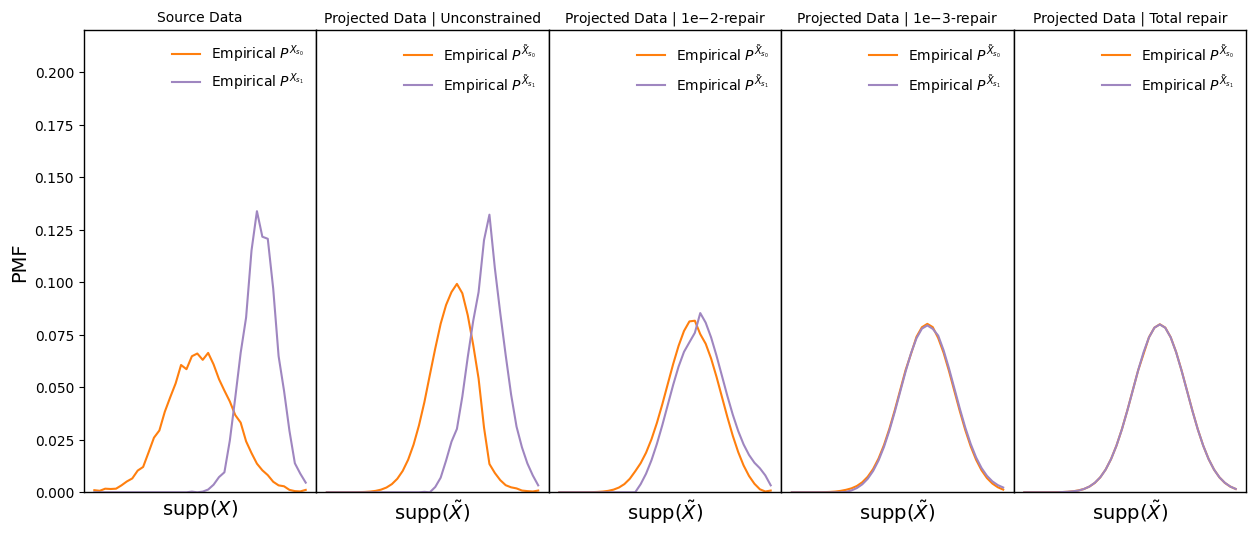

In [ ]:
x_range=example.x_range
dist=example.dist

ymax=0.22
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,5),(0,0), rowspan=1, colspan=1)
dist_tmp=dist_origin
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{X_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{X_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.xticks([])
plt.xlabel(r'supp($X$)',fontsize=14)
plt.ylabel('PMF',fontsize=14)
plt.title('Source Data',fontsize=10)
ax=plt.subplot2grid((1,5),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Unconstrained',fontsize=10)
ax=plt.subplot2grid((1,5),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,4), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig(path+'/plots/groupwise.pdf',bbox_inches = 'tight')

### Final Step: Generate Plot for the Paper

This cell generates the main plot used in the paper.

- It compares the original and projected group-wise distributions under:
  - Baseline (no repair)
  - Partial repair
  - Total repair

- The plot shows how projection affects fairness by visualizing the alignment between group distributions and the target.

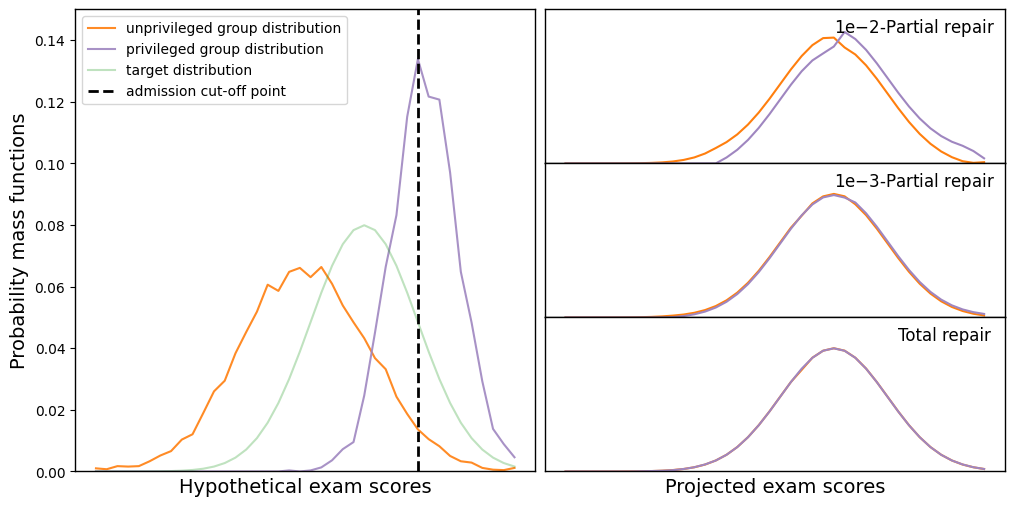

In [ ]:
x_range=example.x_range
dist=example.dist

ymax=0.1
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((3,2),(0,0), rowspan=3, colspan=1)
plt.plot(x_range,dist['x_0'],label='unprivileged group distribution',alpha=0.9,color='tab:orange')
plt.plot(x_range,dist['x_1'],label='privileged group distribution',alpha=0.9,color='#9f86c0')
#plt.plot(x_range,dist['x'],label='group-blind distribution',color='tab:blue')
plt.plot(x_range,dist['t_x'],label='target distribution',alpha=0.3,color='tab:green')
plt.axvline(x=0, color='black', label='admission cut-off point',ls='--', lw=2)
plt.xticks([])
plt.ylim([0,0.15])
plt.ylabel('Probability mass functions',fontsize=14)
plt.xlabel('Hypothetical exam scores',fontsize=14)
plt.legend()
ax=plt.subplot2grid((3,2),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-2}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(1,1), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-3}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(2,1), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.xlabel('Projected exam scores',fontsize=14)
plt.text(1, 0.085, 'Total repair', fontsize=12)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02,hspace=0.)